Формулировка задания с последующей реализацией кода:
В задании вы сами реализуете несколько алгоритмов оптимизации и примените их к определению космологических параметров Вселенной: параметра Хаббла и доли темной энергии в составе Вселенной.

Вам дан файл **jla_mub.txt**, содержащий две колонки: красное смещение сверхновых и модуль расстояния до них (см. заметку о космологическом красном смещении). Модуль расстояния μ задается следующим соотношением:

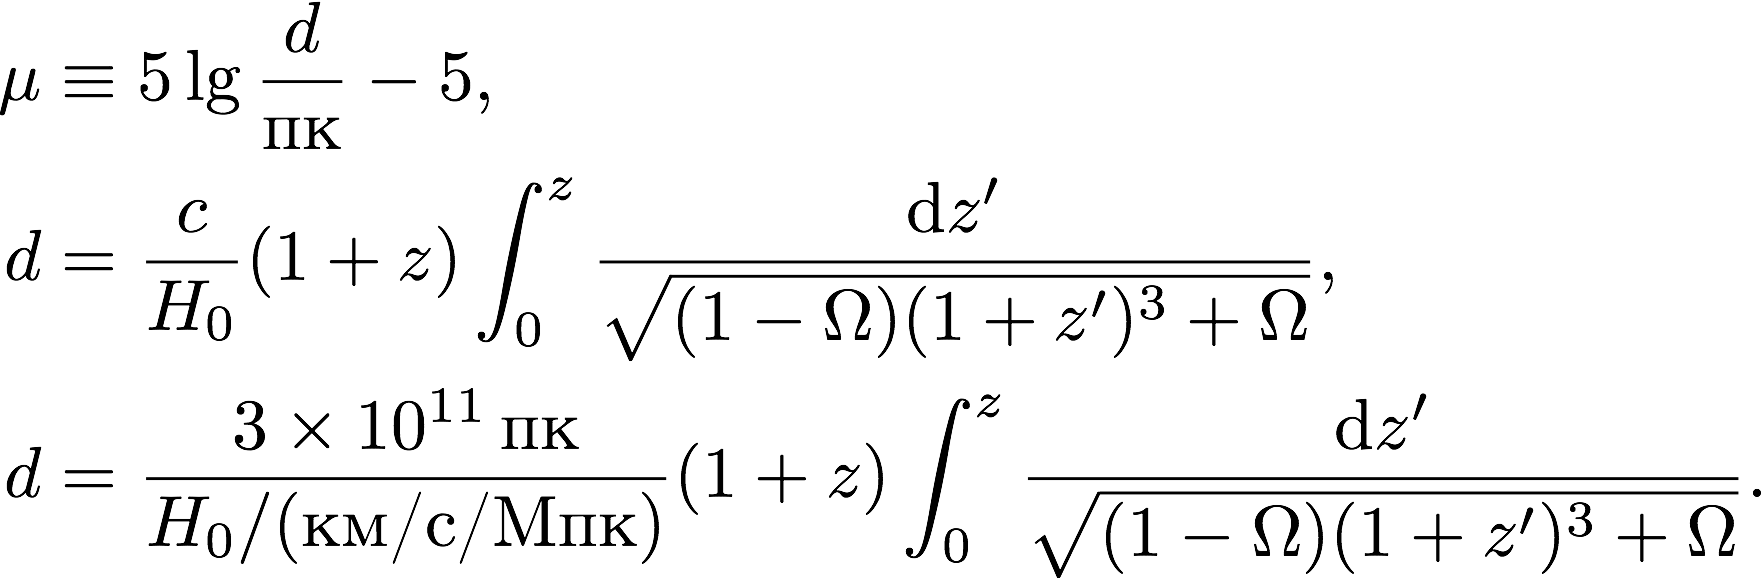

Здесь

z — красное смещение,

d — это фотометрическое расстояние,

c — скорость света,

H_0 — постоянная Хаббла (обычно выражается в км/с/Мпк),

Ω — доля темной энергии в составе Вселененной (от 0 до 1).

В астрономии расстояние часто измеряется в парсеках (пк), но вам ничего не нужно в них переводить, просто используйте вторую формулу для расстояния, а постоянную Хаббла подставляйте в единицах км/с/Мпк.

Вы должны реализовать следующие алгоритмы в файле **opt.py**:

  I. Метод Гаусса—Ньютона в виде функции **gauss_newton(y, f, j, x0, k=1, tol=1e-4)**, где

y — это массив с измерениями,

f(*x) — это функция от неивестных параметров, возвращающая значения, рассчитанные в соответствии с моделью, в виде одномерного массива размера y.size,

j(*x) — это функция от неизвестных параметров, возвращающая якобиан в виде двумерного массива (y.size, x0.size),

x0 — массив с начальными приближениями параметров,

k — положительное число меньше единицы, параметр метода,

tol — относительная ошибка, условие сходимости, параметр метода.

Функция должна возвращать объект класса Result, реализованного в файле opt.py



  II. Метод Левенберга—Марквардта в фиде функции **lm(y, f, j, x0, lmbd0=1e-2, nu=2, tol=1e-4)**, где все одноимённые аргументы имеют те же значения, что и для **gauss_newton**,

lmbd0 — начальное значение парметра lambda метода,

nu — мультипликатор для параметра lambda.

Функция должна возвращать объект класса **Result**

Код из файла opt.py

In [ ]:
%pip install wget

In [ ]:
!python -m wget  https://github.com/MazulovaLisa/file/blob/main/jla_mub.txt -o jla_mub.txt


Saved under jla_mub (2).txt


In [ ]:
from collections import namedtuple
import numpy as np


Result = namedtuple('Result', ('nfev', 'cost', 'gradnorm', 'x'))
Result.__doc__ = """Результаты оптимизации
Attributes
----------
nfev : int
    Полное число вызовов модельной функции
cost : 1-d array
    Значения функции потерь 0.5 sum(y - f)^2 на каждом итерационном шаге.
    В случае метода Гаусса—Ньютона длина массива равна nfev, в случае ЛМ-метода
    длина массива — менее nfev
gradnorm : float
    Норма градиента на финальном итерационном шаге
x : 1-d array
    Финальное значение вектора, минимизирующего функцию потерь
"""
###############################################################


def gauss_newton(y, f, j, x0, k=1, tol=1e-4, max_iter = 1000):
    x = np.asarray(x0, dtype=np.float)
    i = 0
    cost = []
    while True:
        i += 1
        r = f(*x) - y
        cost.append(0.5 * np.dot(r, r))
        jac = j(*x)
        g = np.dot(jac.T, r)
        g_norm = np.linalg.norm(g)
        delta_x = np.linalg.solve(jac.T @ jac, -g)
        x = x + k * delta_x
        if i >= max_iter:
            break
        if np.linalg.norm(delta_x) <= tol * np.linalg.norm(x):
            break
    return Result(nfev=i, cost=cost, gradnorm=g_norm, x=x)


def lm(y, f, j, x0, lmbd0=1e-2, nu=2, tol=1e-4,max_iter=1000):
    x = np.asarray(x0, dtype=float)
    i = 0
    cost = []
    l = lmbd0
    while True:
        i +=1
        jac = j(*x)
        r = f(*x)-y
        cost.append(0.5 * np.dot(r, r))
        g = np.dot(jac.T, r)
        g_norm = np.linalg.norm(g)
        a = np.dot(jac.T,jac)

        ##### расчитаем F(lambda)
        delta_1= np.linalg.solve(a+l*np.eye(a.shape[0]),-g)
        r = f(*(x+delta_1))-y
        F_1 = 0.5*(np.dot(r,r))

        #### расчитаем F(lambda/nu)
        delta_2 = np.linalg.solve(a + l/nu * np.eye(a.shape[0]), -g)
        r = f(*(x + delta_2)) - y
        F_2 = 0.5 * (np.dot(r, r))

        if F_2<=cost[-1]:
            l = l/nu
            x += delta_2
        elif (F_2>cost[-1]) and (F_1 <= cost[-1]):
            x +=delta_1
        else:
            nu_1 = 1.1
            l = l*nu_1
            delta = np.linalg.solve(a + l*np.eye(a.shape[1]), -g)
            r = f(*(x + delta)) - y
            F = 0.5 * (np.dot(r, r))
            while F>cost[-1]:
                l=l*nu_1
                delta = np.linalg.solve(a + l * np.eye(a.shape[1]), -g)
                r = f(*(x + delta)) - y
                F = 0.5 * (np.dot(r, r))
            x = x+delta
        if i>=max_iter:
            break
        if len(cost) > 2 and np.abs(cost[-1] - cost[-2]) <= tol * cost[-1]:
            break
    return Result(nfev= i, cost= cost, gradnorm= g_norm,x= x)

Примените реализованные вами методы Гаусса—Ньютона и Левенберга—Марквардта к решению задачи об определении космологиических постоянных. Вам нужно будет восстановить параметры модели, используя ваши оптимизаторы, в файле **cosmology.py**:

1) Загрузить данные из файла **jla_mub.txt**

2) Восстановить параметры, используя ваши оптимизаторы, подберите параметры оптимизаторов, которые хорошо подходят для данной задачи. 
В качестве начального приближения используйте значения H_0 = 50, Ω = 0.5.

3) Нанести точки из файла на график зависимости μ от z. Там же построить модельную кривую, используя найденные параметры. Сохраните график в файл **mu-z.png**

4) На другом графике построить зависимость функции потерь **sum(0.5 * (y-f)^2)** от итерационного шага для обоих алгоритмов. Сохраните график в файл **cost.png**

5) Выведите в файл **parameters.json** результаты в виде:


In [ ]:
{
  "Gauss-Newton": {"H0": 55, "Omega": 0.55, "nfev": 155},
  "Levenberg-Marquardt": {"H0": 45, "Omega": 0.45, "nfev": 145}
}

{'Gauss-Newton': {'H0': 55, 'Omega': 0.55, 'nfev': 155},
 'Levenberg-Marquardt': {'H0': 45, 'Omega': 0.45, 'nfev': 145}}

Для численного взятия интеграла рекомендуется использовать функцию **scipy.integrate.quad.**

In [4]:

import math as m
import numpy as np
from scipy.integrate import quad as q
import matplotlib.pyplot as plt
import json


def integ_1(z,om):
    f = lambda x: 1/m.sqrt(om +(1-om)*(1+x)**3)
    return np.array([q(f,0,x)[0] for x in z])

def integ_2(z,om):
    f = lambda x: 0.5*((1+x)**3-1)*m.sqrt(om +(1-om)*(1+x)**3)**(-1.5)
    return np.array([q(f,0,x)[0] for x in z])

###Функция mu=f(z) с параметрам H0, Omega
def mu(z,h0,om):
    return 5*np.log10(3e11/h0*(1+z)*integ_1(z,om))-5



####Якобиан
def j(z, h0, om):
    j = np.empty((z.size, 2))
    j[:, 0] = -5/(h0*m.log(10))
    j[:, 1] = 5/m.log(10)*np.divide(integ_2(z,om),integ_1(z,om))
    return j



    data = np.genfromtxt('jla_mub.txt',dtype = float, names = ['z','mu'])
    ## x_0 = [H0,Omega]
    x_0 = np.array([50, 0.5])
    z = data['z']
    mu_vec = data['mu']

    res1 = opt.lm(mu_vec,
                lambda *x: mu(z, *x),
                lambda *x: j(z, *x),
                x_0)

    x_0 = np.array([50, 0.5])
    res2 = opt.gauss_newton(mu_vec,
                lambda *x: mu(z, *x),
                lambda *x: j(z, *x),
                x_0)

    ##Построение кривых
    plt.scatter(z,mu_vec, label='Data')
    plt.plot(z,mu(z,*res2.x),'-', color = 'r', label = 'Гаусс-Ньютон')
    plt.plot(z,mu(z,*res1.x),'*', color = 'black', label= 'Левенберг—Марквардт')
    plt.ylabel('Модуль расстояния ')
    plt.xlabel('Красное смещение ')
    plt.title('$mu(z)$')
    plt.grid()
    plt.legend()
    plt.savefig('mu-z.png')
    plt.cla()

    ##Построение ошибки
    plt.plot(range(res1.nfev), res1.cost,
        color = 'g', label = 'Левенберг—Марквардт')
    plt.plot(range(res2.nfev), res2.cost,':',color = 'r', label='Гаусс-Ньютон')
    plt.xlabel('Номер итерации' )
    plt.ylabel('Значение функции ошибок')
    plt.legend()
    plt.grid()
    plt.savefig('cost.png')

    ###Запись в Json
    ans = {
        "Gauss-Newton": {"H0": res2.x[0], "Omega": res2.x[1], "nfev": res2.nfev},
        "Levenberg-Marquardt": {"H0": res1.x[0], "Omega": res1.x[1], "nfev": res1.nfev}
        }
    with open('parameters.json', 'w') as f:
        json.dump(ans, f)